In [9]:
from math import log,exp,sqrt
from scipy import stats
import pandas as pd
import numpy as np
import pyecharts

# 内容
## 定价模型 希腊字母(函数)
## 组合损益图 3D图

# 期权BS定价模型
## d1 = (ln(st/k)+(r+1/2\*sigma)\*T)/(sigma\*sqrt(T))
## d2 = d1 - sigma\*sqrt(T)
## call = st \*N(d1)-k \*exp(-r \*T) \*N(d2)
## put = k\*exp(-r\*T)\*N(-d2)-st\*N(-d1)


In [16]:
def call(st,k,r,T,sigma):
    '''
    st,k,r,T,sigma(T以年为单位，天数应该除以365)
    '''
    d1 = (log(st/k)+(r+1/2*sigma)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    call = st*stats.norm.cdf(d1)-k*exp(-r*T)*stats.norm.cdf(d2)
    return call
def put(st,k,r,T,sigma):
    '''
    st,k,r,T,sigma(T以年为单位，天数应该除以365)
    '''
    d1 = (log(st/k)+(r+1/2*sigma)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    put = k*exp(-r*T)*stats.norm.cdf(-1*d2)-1*st*stats.norm.cdf(-1*d1)
    return put

# Delta
## call :delta = N(d1)
## put :delta = N(-d1)

In [19]:
def delta(st,k,r,T,sigma,n=1):
    '''
    n默认为1看涨期权的delta
    n为-1为看跌期权的delta
    '''
    d1 = (log(st/k)+(r+1/2*sigma)*T)/(sigma*sqrt(T))
    delta = n*stats.norm.cdf(n*d1)
    return delta

# Gamma
##  gamma = N＇(d1)/(st\*sigma\*sqrt(T))

In [37]:
def gamma(st,k,r,T,sigma):
    d1 = (log(st/k)+(r+1/2*sigma)*T)/(sigma*sqrt(T))
    gamma = stats.norm.pdf(d1)/(st*sigma*sqrt(T))
    return gamma

# Theta
## call: theta = -1\*(st\*N＇(d1)\*sigma)/(2\*sqrt(T))-r×k\*exp(-r \*T)\*N(d2)
## put:theta = -1\*(st\*N＇(d1)\*sigma)/(2\*sqrt(T))+r×k\*exp(-r \*T)\*N(-1\*d2)

In [22]:
def theta(st,k,r,T,sigma,n=1):
    '''
    n默认为1看涨期权的delta
    n为-1为看跌期权的delta
    '''
    d1 = (log(st/k)+(r+1/2*sigma)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    theta = -1*(st*stats.norm.pdf(d1)*sigma)/(2*sqrt(T))-n*r*k*exp(-r*T)*stats.norm.cdf(n*d2)
    return theta

# Vega
## vega = st\*sqrt(T)*N＇(d1)

In [23]:
def vega(st,k,r,T,sigma):
    d1 = (log(st/k)+(r+1/2*sigma)*T)/(sigma*sqrt(T))
    vega = st*sqrt(T)*stats.norm.pdf(d1)
    return vega

# 希腊字母画图

In [40]:
#画图函数
from pyecharts import Surface3D

def create_surface3d_data(func,st,k,r,T,sigma):
    for t0 in T:
        y = t0
        for t1 in k:
            x = t1
            z = func(st,t1,r,t0,sigmas)
            yield [x, y, z]
def plots(func,strs,st,k,r,T,sigma):
    range_color = [
    "#313695",
    "#4575b4",
    "#74add1",
    "#abd9e9",
    "#e0f3f8",
    "#ffffbf",
    "#fee090",
    "#fdae61",
    "#f46d43",
    "#d73027",
    "#a50026",
    ]
    _data = list(create_surface3d_data(func,st,k,r,T,sigma))
    surface3d = Surface3D(strs, width=1200, height=600)
    surface3d.add(
        "",
        _data,
        is_visualmap=True,
        visual_range_color=range_color,
        visual_range=[-70,0 ],
        grid3d_rotate_sensitivity=1,
        xaxis3d_min=80,
    )
    return surface3d

In [43]:
#delta
k = np.linspace(80,120,100)
T = np.linspace(0.01,1,100)
st = 100
r = log(1+0.065)
sigma = 0.4
plots(delta,'delta',st,k,r,T,sigma)

In [44]:
plots(gamma,'gamma',st,k,r,T,sigma)

In [45]:
plots(vega,'vega',st,k,r,T,sigma)

In [46]:
plots(theta,'theta',st,k,r,T,sigma)

# 期权组合损益图

In [92]:
def line_op(kind,x,y,name):
    kind.add(name,x,y,is_label_show=True)
    return kind

In [93]:
#损益计算
def buy(st,k,qlj,n=1):
    '''
    n=1 call
    n=-1 put
    '''
    lists = []
    for i in st:
        profit = max(n*(i-k)-qlj,-qlj)  #max(k-st-qlj,-qlj)
        lists.append(profit)
    return lists
def sell(st,k,qlj,n=1):
    '''
    n=1 call
    n=-1 put
    '''
    lists = []
    for i in st:
        profit = -1*max(n*(i-k)-qlj,-qlj)  #max(k-st-qlj,-qlj)
        lists.append(profit)
    return lists

# 领子期权

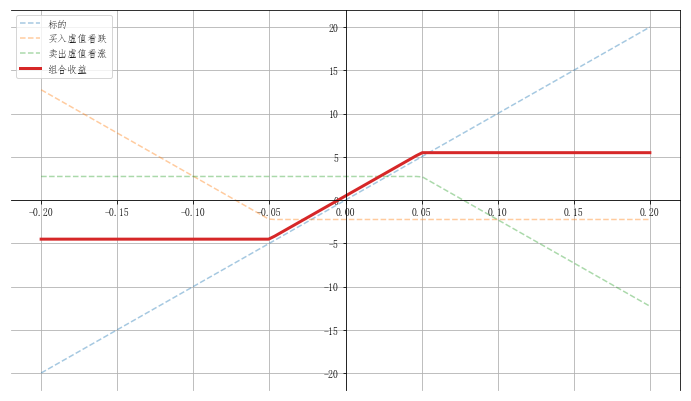

In [148]:
#1.买入一份标的资产p1
#2.买入虚值看跌p2
#3.卖出虚值看涨p3
s1 = 100  
c_k = 105
p_k = 95
r = 0.05
T = 30/365
sigma = 0.4
st = np.linspace(80,120,100)
c = call(s1,c_k,r,T,sigma)
p = put(s1,p_k,r,T,sigma)
p1 = []
for i in st:
    p1.append(i-s1)
p2 = buy(st,p_k,p,-1)
p3 = sell(st,c_k,c)
sum_p = []
for i in range(len(p1)):
    sum_p.append(p1[i]+p2[i]+p3[i])
    
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

mpl.rcParams['font.sans-serif']=['FangSong'] #用来正常显示中文标签
mpl.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.figure(figsize=(12,7))
plt.plot(st/100-1,p1,label='标的',alpha=0.4,linestyle='--')
plt.plot(st/100-1,p2,label='买入虚值看跌',alpha=0.4,linestyle='--')
plt.plot(st/100-1,p3,label='卖出虚值看涨',alpha=0.4,linestyle='--')
plt.plot(st/100-1,sum_p,linewidth=3,label='组合收益')
plt.grid(True)
ax = plt.gca()
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_position(('data', 0))
ax.legend()

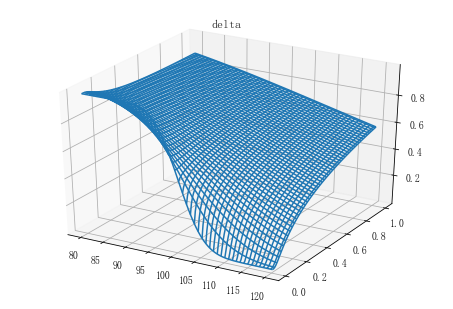

In [156]:
#pyecharts 画的图上传后无法显示 这边用matplotlib再画一次
def matplot_op(func,st,k,T,r,sigma):
    fig = plt.figure()
    ax = Axes3D(fig)
    z = np.zeros((len(k),len(T)))
    for j in range(len(k)):
        for i in range(len(T)):
            z[i,j] = func(st,k[j],r,T[i],sigma)
    k,T = np.meshgrid(k,T)
    ax.plot_wireframe(k,T,z)
from mpl_toolkits.mplot3d import Axes3D
k = np.linspace(80,120,100)
T = np.linspace(0.01,1,100)
st = 100
r = log(1+0.065)
sigma = 0.4
matplot_op(delta,st,k,T,r,sigma)
plt.title('delta');

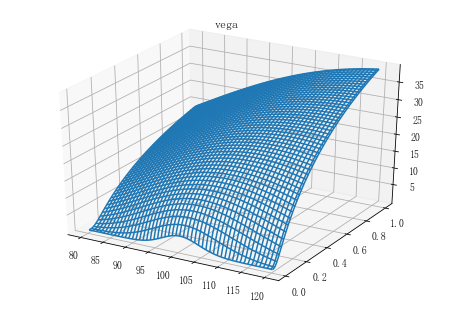

In [158]:
matplot_op(vega,st,k,T,r,sigma)
plt.title('vega');

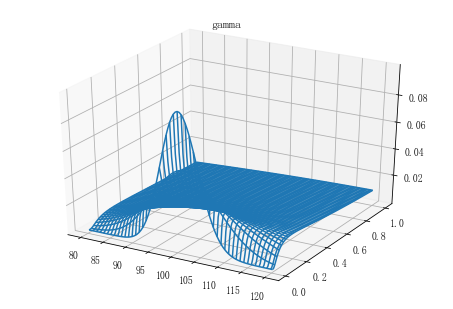

In [162]:
matplot_op(gamma,st,k,T,r,sigma)
plt.title('gamma');

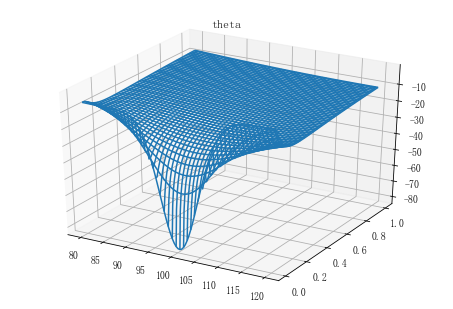

In [161]:
matplot_op(theta,st,k,T,r,sigma)
plt.title('theta');